# 主要データサイエンスモデルのLightGBMをテンプレ化する
これにより、大幅な業務の効率化を推進できる

## 分析準備
使用するライブラリとデータの読み込みをする

In [73]:
import warnings
warnings.simplefilter('ignore')
# 使用ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# データの読み込み(著名なタイタニックデータ)
train = pd.read_csv(r'C:\Users\t-oka\OneDrive\ドキュメント\titanic_train.csv')
test = pd.read_csv(r'C:\Users\t-oka\OneDrive\ドキュメント\titanic_test.csv')

In [75]:
# 訓練データの確認
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [76]:
# テストデータの確認。★survivedがない
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [77]:
# データサイズの確認
print("train.shape{}, test.shape{}".format(train.shape, test.shape))

train.shape(891, 12), test.shape(418, 11)


# データの可視化＆チェック
データの中身を確認する部分。可視化も

## 統計量の確認

In [78]:
# 訓練データの統計量を算出
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [79]:
# テストデータの統計量を算出
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [80]:
import collections
categorical = ['Sex', 'SibSp', 'Ticket', 'Cabin', 'Embarked']
for c in categorical:
    print(f'・{c}: ', collections.Counter(train[c])) 
    # male(男)の方が多いとわかる
    # チケットがよくわからん！！⇒CAなどだけ取り出さないと過適合する

・Sex:  Counter({'male': 577, 'female': 314})
・SibSp:  Counter({0: 608, 1: 209, 2: 28, 4: 18, 3: 16, 8: 7, 5: 5})
・Ticket:  Counter({'347082': 7, '1601': 7, 'CA. 2343': 7, '3101295': 6, 'CA 2144': 6, '347088': 6, '382652': 5, 'S.O.C. 14879': 5, '349909': 4, '347077': 4, '19950': 4, 'W./C. 6608': 4, '4133': 4, 'LINE': 4, '113781': 4, '17421': 4, 'PC 17757': 4, '113760': 4, '2666': 4, '347742': 3, 'SC/Paris 2123': 3, 'PC 17572': 3, 'C.A. 34651': 3, '371110': 3, '230080': 3, '363291': 3, '35273': 3, 'C.A. 31921': 3, '110152': 3, 'PC 17755': 3, '110413': 3, 'PC 17582': 3, 'PC 17760': 3, '13502': 3, '239853': 3, 'F.C.C. 13529': 3, '29106': 3, '345773': 3, '248727': 3, '24160': 3, '113803': 2, '237736': 2, 'PP 9549': 2, '239865': 2, 'PC 17569': 2, 'PC 17604': 2, '113789': 2, '345764': 2, '2651': 2, '11668': 2, '349237': 2, '113572': 2, '36973': 2, '2661': 2, '248738': 2, '364516': 2, '3101278': 2, 'C.A. 2315': 2, '231919': 2, '244367': 2, '35281': 2, '110465': 2, '2665': 2, '2627': 2, 'PC 175

## 正解ラベルとの関係を確認

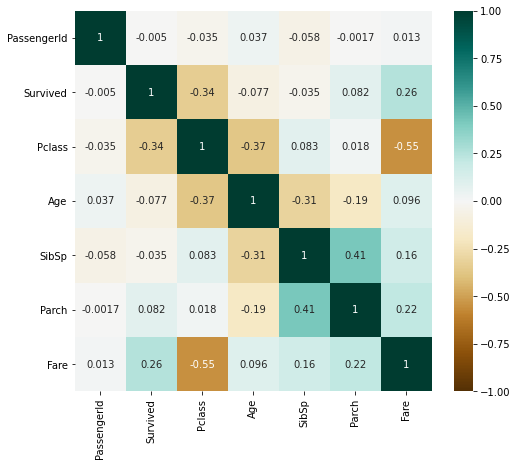

In [81]:
# 数値変数間の相関係数のヒートマップ
fig = plt.figure(figsize=(8,7))
ax = sns.heatmap(train.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1)
# 下記で.png保存も可能
# fig.savefig('titanic_heatmap.png', bbox_inches='tight')

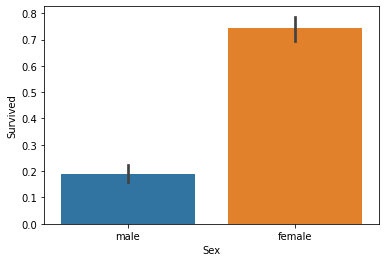

In [82]:
# カテゴリ変数(Sex)とSurvivedの関係
fig = plt.figure(figsize=(6,4))
ax = sns.barplot(y='Survived', x='Sex', data=train)
# 下記で.png保存できる。femaleのほうがたくさん生き残っている
# fig.savefig('titanic_Survived(男女別).png', bbox_inches='tight')

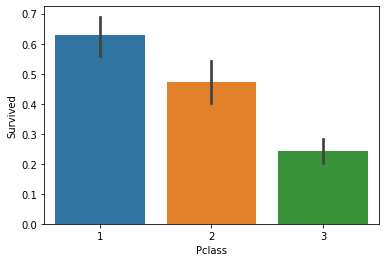

In [83]:
## カテゴリ変数(Pclass)とSurvivedの関係
fig = plt.figure(figsize=(6,4))
ax = sns.barplot(y='Survived', x='Pclass', data=train) # クラスが高いほど生き残っている(1 > 2 > 3)

## データの欠損の確認

In [84]:
# データの欠損の確認
print("●train\n{}".format(train.isnull().sum()))
print("●test\n{}".format(test.isnull().sum()))

●train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
●test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


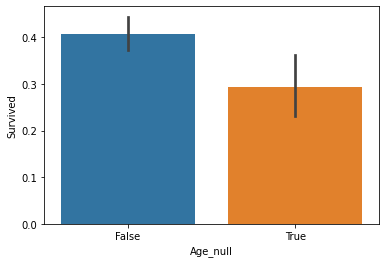

In [14]:
# 年齢の欠損とSurvivedの関係
train["Age_null"] = train["Age"].isnull()

fig = plt.figure(figsize=(6,4))
sns.barplot(y='Survived', x='Age_null', data=train)
# fig.savefig('titanic_EDA_AgeNull_Survived.png', bbox_inches='tight')

del train["Age_null"] # Null(身元がはっきりしない)のほうがたくさん死んでいる

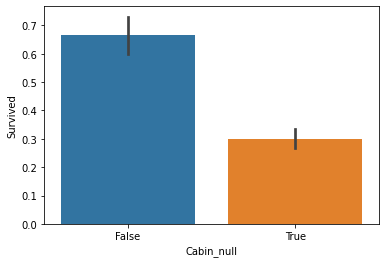

In [30]:
# Cabinの欠損とSurvivedの関係
train["Cabin_null"] = train["Cabin"].isnull()

fig = plt.figure(figsize=(6,4))
sns.barplot(y='Survived', x='Cabin_null', data=train)
# fig.savefig('titanic_EDA_AgeNull_Survived.png', bbox_inches='tight')

del train["Cabin_null"] # Null(身元がはっきりしない)のほうがたくさん死んでいる⇒Nullかどうかは重要とわかる

# データの前処理

In [31]:
# ライブラリインポート
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## データの前処理

In [32]:
# NameをTitleに変換する関数
def replace_name(series):
    series = series.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    series = series.replace(['Capt','Col','Major','Dr','Rev'], 'Officer')
    series = series.replace(['Don','Sir','the Countess','Lady','Dona'], 'Royalty')
    series = series.replace(['Mme','Ms'], 'Mrs')
    series = series.replace(['Mlle'], 'Miss')
    series = series.replace(['Jonkheer'], 'Master')
    return series

In [85]:
# カテゴリカル変数の定義
categorical_features = ["Sex", "Embarked", "Title"]

In [86]:
# 特徴量エンジニアリングの実行
train = train.dropna(subset=['Embarked'])
df = pd.concat([train, test])
df['Family'] = df['SibSp'] + df['Parch'] + 1
df["Title"] = replace_name(df["Name"])
df["Age_null"] = df["Age"].isnull()
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df[df["Pclass"]==3]["Fare"].median())
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'])
oe = OrdinalEncoder()
df[categorical_features] = oe.fit_transform(df[categorical_features]).astype(int)
train = df[df["Survived"].notnull()]
test = df[df["Survived"].isnull()].drop(columns=["Survived"])
train0 = train # 公差検証用にescape

## データセット作成

In [87]:
# 訓練データを学習データと検証データに分割
train, valid = train_test_split(train, test_size=0.2, stratify=train["Survived"], random_state=100)

In [88]:
# データの保存
train.to_csv("train_proc.csv",index=None)
valid.to_csv("valid_proc.csv",index=None)
test.to_csv("test_proc.csv",index=None)

In [89]:
# 説明変数と目的変数に分割
def make_Xy(df, col_y="Survived"):
    return df.drop(columns=[col_y]), df[col_y]

train0_X, train0_y = make_Xy(train0)
train_X, train_y = make_Xy(train)
valid_X, valid_y = make_Xy(valid)
test_X = test

# モデルの学習

In [90]:
# ライブラリインポート
from lightgbm import LGBMClassifier
import pickle as pkl

In [91]:
# モデルの定義
model = LGBMClassifier(max_depth=10, colsample_bytree=0.5, 
                       reg_lambda=0.5, reg_alpha=0.5, 
                       importance_type="gain", random_state=100)

In [92]:
# 学習の実行
model.fit(
    train_X, train_y,
    eval_set=[(valid_X, valid_y)],
    early_stopping_rounds=50,
    verbose=10,
    categorical_feature=categorical_features
)

[10]	valid_0's binary_logloss: 0.484339
[20]	valid_0's binary_logloss: 0.435251
[30]	valid_0's binary_logloss: 0.417806
[40]	valid_0's binary_logloss: 0.413229
[50]	valid_0's binary_logloss: 0.413939
[60]	valid_0's binary_logloss: 0.413546
[70]	valid_0's binary_logloss: 0.412299
[80]	valid_0's binary_logloss: 0.410329
[90]	valid_0's binary_logloss: 0.412802
[100]	valid_0's binary_logloss: 0.414618


LGBMClassifier(colsample_bytree=0.5, importance_type='gain', max_depth=10,
               random_state=100, reg_alpha=0.5, reg_lambda=0.5)

In [93]:
# 正解率の計算
print("Accuracy(train) {:.3f}".format(model.score(train_X, train_y)))
print("Accuracy(valid) {:.3f}".format(model.score(valid_X, valid_y)))

Accuracy(train) 0.885
Accuracy(valid) 0.826


In [94]:
# モデルの保存
with open('lgbm_model.pkl', 'wb') as f:
    pkl.dump(model, f)

In [107]:
# パラメーターチューニングを行う（グリッドサーチ）+公差検証(K-FOLD)
import time
from sklearn.model_selection import GridSearchCV
from seaborn_analyzer import regplot
from sklearn.model_selection import KFold
seed = 42
scoring = 'accuracy' 
start = time.time()
# 最終的なパラメータ範囲（1152通り）
params = {'reg_alpha': [0.0001, 0.003, 0.1],
             'reg_lambda': [0.0001, 0.1],
             'colsample_bytree': [0.3, 0.4, 0.5],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 1, 2]
             }
cv = KFold(n_splits=3, shuffle=True, random_state=seed)
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(model, params, cv=cv,
                      scoring=scoring, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(train0_X, train0_y) # train0_X, train0_yの使用
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒') # paramsを変えて何回かやる必要がある。3～5回は[]を書き換えて試す。

最適パラメータ {'colsample_bytree': 0.4, 'reg_alpha': 0.0001, 'reg_lambda': 0.1, 'subsample': 0.4, 'subsample_freq': 1}
スコア 0.8267585767585768
所要時間10.246723890304565秒


In [108]:
best_params # ★lightGBMはnum_treesを[]から選んだりせずに、勝手に決めてくれた方が精度がよさそう
# グリッドサーチはしなくてよい。Optuna(自動最適化)は気になるのでやっておく。

{'colsample_bytree': 0.4,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.1,
 'subsample': 0.4,
 'subsample_freq': 1}

In [110]:
# bestパラメターで再学習
model = LGBMClassifier(colsample_bytree=0.4,
                       reg_alpha=0.003, reg_lambda=0.1, subsample=0.4, subsample_freq=1)
model.fit(
    train_X, train_y,
    eval_set=[(valid_X, valid_y)],
    early_stopping_rounds=50,
    verbose=10,
    categorical_feature=categorical_features
)
# 正解率の計算
print("Accuracy(train) {:.3f}".format(model.score(train_X, train_y)))
print("Accuracy(valid) {:.3f}".format(model.score(valid_X, valid_y)))

[10]	valid_0's binary_logloss: 0.490814
[20]	valid_0's binary_logloss: 0.448135
[30]	valid_0's binary_logloss: 0.433137
[40]	valid_0's binary_logloss: 0.436585
[50]	valid_0's binary_logloss: 0.429981
[60]	valid_0's binary_logloss: 0.424795
[70]	valid_0's binary_logloss: 0.421657
[80]	valid_0's binary_logloss: 0.42245
[90]	valid_0's binary_logloss: 0.417965
[100]	valid_0's binary_logloss: 0.420144
Accuracy(train) 0.866
Accuracy(valid) 0.815


<AxesSubplot:>

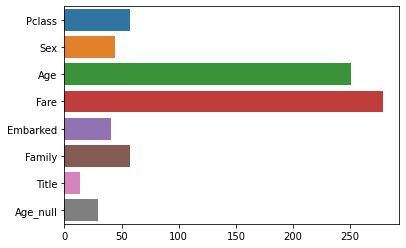

In [111]:
# 重要度
fig = plt.figure(figsize=(6,4))
sns.barplot(x=model.feature_importances_, y=model.feature_name_)
# fig.savefig('titanic_feature_importance.png', bbox_inches='tight')

# XAI 可視化により、機械学習を理解する

In [104]:
import shap
# 説明器の準備～SHAP値算出
exp = shap.TreeExplainer(model)
test_sv = exp.shap_values(test_X)
test_sv = test_sv[1]
# もとのデータセットと同じサイズの行列が得られる
print(test_X.shape, test_sv.shape)
print(sv_test[0])

(418, 8) (418, 8)
[-0.49470988 -0.65953759 -0.12863773 -0.08027737 -0.07017911  0.06905329
 -0.4919526   0.03390263]


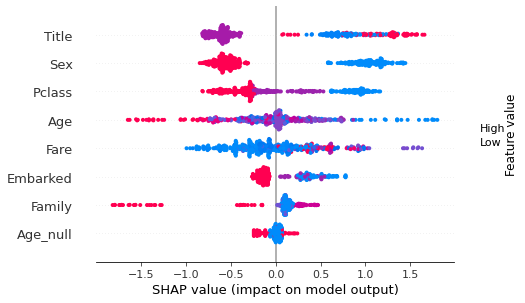

In [105]:
shap.summary_plot(test_sv, test_X)

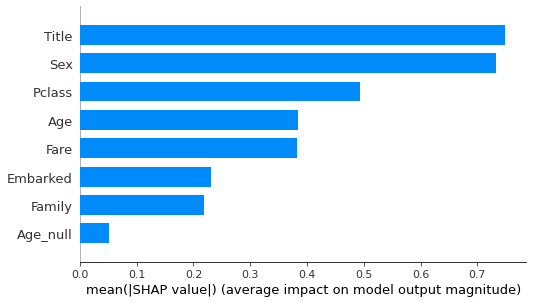

In [106]:
shap.summary_plot(test_sv, test_X, plot_type="bar") 
# 今回は上のshap-ray値を考えない場合と同じようになっている(当然違う場合もある)